<span style="color: orange; font-family: Calibri Light;">
  <h1><b>TIME SERIES ANALYSIS</b></h1>
</span>
<span style = "font-family: Calibri Light">

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>I. Setting Up Environment</b></h2>
</span>

In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
import csv

import datetime
import os
from glob import glob

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from cycler import cycler



pio.templates.default = "plotly_white"

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>II. Load & Transform Datasets</b></h2>
</span>

In [13]:
# Access dataset files
folder_path = os.path.join( "..", "bert_model_data") 
file_type = "*.csv"

# List of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../bert_model_data/bert_default_raw_text_topics_term.csv',
 '../bert_model_data/bert_default_sw2 _text_topics_term.csv',
 '../bert_model_data/test_data_bert_raw_label.csv',
 '../bert_model_data/bert_train_lemma.csv',
 '../bert_model_data/human_and_bert_raw_labels.csv',
 '../bert_model_data/bert_default_raw_text_topics_term_labelled.csv',
 '../bert_model_data/test_data_human_label_bert_raw.csv',
 '../bert_model_data/posts_upvote_ratio.csv',
 '../bert_model_data/bert_model_2_labelled_train_data.csv',
 '../bert_model_data/bert_sw_test_data.csv',
 '../bert_model_data/bert_train_no_prep.csv',
 '../bert_model_data/bert_model_1_label_train_data.csv',
 '../bert_model_data/bert-data-sw.csv',
 '../bert_model_data/human_and_model_labels_model2.csv',
 '../bert_model_data/bert_model_w2v_label_train_data.csv',
 '../bert_model_data/test_data_lemma.csv',
 '../bert_model_data/bert_kmeans_test_data.csv',
 '../bert_model_data/bert_w2v_test_data.csv',
 '../bert_model_data/bert_model_kmeans_label_train_d

In [3]:
def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)

In [4]:
#import cleaned data
train_data = pd.read_csv('../bert_model_data/bert_model_2_labelled_train_data.csv')#, converters ={'tokens':list_converter})
train_data = train_data.drop(columns = ['Unnamed: 0'])
train_data.head()

,text_type,ID,date_created,year,long_text,prep_text,topic,topic_name
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.,-1,-1_life_uae_city_didn
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!""",14,14_award_god bless_wholesome_luck
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...,18,18_font_instagram_painting_camera
3,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ...",0,0_sharjah_uae_muslim_dubai police
4,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common give prince william harry a break he ju...,-1,-1_life_uae_city_didn


In [5]:
train_data.drop(columns = ['year', 'prep_text','topic_name'], inplace = True)
train_data.head()

,text_type,ID,date_created,long_text,topic
0,comment,c5c54q4,2012-07-11 00:50:58,That dessert's a bit rich for me.,-1
1,comment,c5edn0u,2012-07-15 21:59:34,"""A SILVER one?! I HATE YOU DAD!""",14
2,comment,c6d18gk,2012-09-25 07:57:13,Yet i stared at the picture for a good 45 seco...,18
3,comment,c6d2fss,2012-09-25 09:13:23,"[FYSR] = from your sister subreddit.\n\nIMO, i...",0
4,comment,c6d46es,2012-09-25 12:32:08,common give prince william harry a break he ju...,-1


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98957 entries, 0 to 98956
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     98957 non-null  object
 1   ID            98957 non-null  object
 2   date_created  98957 non-null  object
 3   long_text     98957 non-null  object
 4   topic         98957 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [8]:
test_data = pd.read_csv('../bert_model_data/human_and_model_labels_model2.csv')
test_data.drop(columns = ['Unnamed: 0','human_topic_desc', 'human_topic_no','model_topic_desc'],inplace = True)

test_data

,text_type,ID,date_created,long_text,model_topic_no
0,submission,10embj,2012-09-24 23:02:05,Dubai cap my dad brought me! [FYSR],-1
1,submission,13ch705,2023-05-09 10:04:19,Anyone here have any idea where I can park my ...,4
2,submission,13cpma4,2023-05-09 17:17:49,"UAE real estate agents and brokers, I need you...",12
3,submission,13p1nlq,2023-05-23 00:07:39,A Well Deserved Shout-out I posted in this sub...,3
4,submission,14d7052,2023-06-19 10:52:36,Furnished apartments… bedding/pots and pans Hi...,12
...,...,...,...,...,...
1195,submission,wbwik,2012-07-10 19:11:08,Only in Dubai! R8: BRAND NEW 2012 Audi R8 V8 -...,-1
1196,submission,x9rwby,2022-09-09 14:27:16,Where have all the saris gone ? Was having a c...,23
1197,submission,ye87w0,2022-10-27 00:35:22,Yeah those vox movies somehow also got affecte...,24
1198,submission,z1qtro,2022-11-22 15:06:04,Unbaked croissant Any idea where you can buy u...,-1


In [13]:
ts_data.dropna?

Signature:
ts_data.dropna(
    *,
    axis: 'Axis' = 0,
    how: 'AnyAll | NoDefault' = <no_default>,
    thresh: 'int | NoDefault' = <no_default>,
    subset: 'IndexLabel' = None,
    inplace: 'bool' = False,
    ignore_index: 'bool' = False,
) -> 'DataFrame | None'
Docstring:
Remove missing values.

See the :ref:`User Guide <missing_data>` for more on which values are
considered missing, and how to work with missing data.

Parameters
----------
axis : {0 or 'index', 1 or 'columns'}, default 0
    Determine if rows or columns which contain missing values are
    removed.

    * 0, or 'index' : Drop rows which contain missing values.
    * 1, or 'columns' : Drop columns which contain missing value.

    Pass tuple or list to drop on multiple axes.
    Only a single axis is allowed.

how : {'any', 'all'}, default 'any'
    Determine if row or column is removed from DataFrame, when we have
    at least one NA or all NA.

    * 'any' : If any NA values are present, drop that row or column

In [9]:
#merge train & test data
test_data.rename(columns = {'model_topic_no': 'topic'}, inplace = True)
ts_data = pd.concat([train_data, test_data], axis = 0, ignore_index = True)

ts_data.dropna(inplace = True, ignore_index = True)
ts_data.head()

,text_type,ID,date_created,long_text,topic
0,comment,c5c54q4,2012-07-11 00:50:58,That dessert's a bit rich for me.,-1
1,comment,c5edn0u,2012-07-15 21:59:34,"""A SILVER one?! I HATE YOU DAD!""",14
2,comment,c6d18gk,2012-09-25 07:57:13,Yet i stared at the picture for a good 45 seco...,18
3,comment,c6d2fss,2012-09-25 09:13:23,"[FYSR] = from your sister subreddit.\n\nIMO, i...",0
4,comment,c6d46es,2012-09-25 12:32:08,common give prince william harry a break he ju...,-1


In [10]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100157 entries, 0 to 100156
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text_type     100157 non-null  object
 1   ID            100157 non-null  object
 2   date_created  100157 non-null  object
 3   long_text     100157 non-null  object
 4   topic         100157 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [15]:
#get the label pairing: topic_no --> topic_description
label_data = pd.read_csv('../bert_model_data/bert_default_sw2 _text_topics_term.csv', converters ={'tokens':list_converter})
label_data = label_data[['Topic','Representation', 'human labels', 'Broad categories']]
label_data.head()

,Topic,Representation,human labels,Broad categories
0,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
1,0,"['sharjah', 'uae', 'muslim', 'dubai police', '...",undefined,NaN
2,1,"['expo', 'weather', 'summer', 'ac', 'burj khal...",weather_and_landmarks,environment
3,2,"['vat', 'maid', 'years experience', '5k', 'cv'...",employment,economy
4,3,"['tip', 'talabat', 'deliveroo', 'zomato', 'res...",dining_services_delivery,living


In [17]:
#rename columns
label_data.rename(columns = {'Topic': 'topic',
                            'Representation': 'representation',
                            'human labels': 'human_labels',
                            'Broad categories': 'broad_categories'}, inplace = True)
label_data.head()

,topic,representation,human_labels,broad_categories
0,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
1,0,"['sharjah', 'uae', 'muslim', 'dubai police', '...",undefined,NaN
2,1,"['expo', 'weather', 'summer', 'ac', 'burj khal...",weather_and_landmarks,environment
3,2,"['vat', 'maid', 'years experience', '5k', 'cv'...",employment,economy
4,3,"['tip', 'talabat', 'deliveroo', 'zomato', 'res...",dining_services_delivery,living


In [20]:
# Create a mapping dictionary 
topic_mapping = label_data.set_index('topic')[['representation', 'human_labels','broad_categories' ]].to_dict(orient='index')

# Map the values from label_data to train_data based on the 'Topic' column
ts_data['representation'] = ts_data['topic'].map(lambda x: topic_mapping[x]['representation'])
ts_data['human_labels'] = ts_data['topic'].map(lambda x: topic_mapping[x]['human_labels'])
ts_data['broad_categories'] = ts_data['topic'].map(lambda x: topic_mapping[x]['broad_categories'])

In [21]:
ts_data.sample(n=10)

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories
54928,comment,i3832fx,2022-04-03 18:05:19,Better labor laws.\nEdit: implementation of la...,2,"['vat', 'maid', 'years experience', '5k', 'cv'...",employment,economy
50281,comment,hr4h0rw,2022-01-04 01:13:37,"Definitely, I haven't had to pay delivery char...",-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
28704,comment,giix1o2,2021-01-08 13:09:47,I’d love to know if u have a google pin of this?,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
937,comment,dln6xsw,2017-08-15 11:14:29,Well mention IBCG and I was expecting it. I ca...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
90724,comment,jkt0jc1,2023-05-19 22:30:48,Max Metro Station at Al Jafiliya,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
38243,comment,h02o8f6,2021-05-31 16:01:31,I have been to many Mango-producing countries ...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
74543,comment,iw091ef,2022-11-12 02:54:23,My only advise to you is to not stress out,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
23858,comment,gbbnx48,2020-11-06 11:26:53,I am loving this!! Take an upvote you guys.,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
73399,comment,itbntwg,2022-10-22 16:22:32,I believe it is also cultural understanding. A...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
29826,comment,gkpoj2g,2021-01-25 19:07:03,100% you will be failed. For not checking mirr...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN


In [22]:
#check for duplicates
ts_data[ts_data.duplicated()]

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories


In [23]:
#extract submissions for time series analysis
submissions = ts_data[ts_data.text_type == 'submission'].copy().reset_index()

In [24]:
submissions.drop(columns = ['index'], axis = 1, inplace = True)
submissions.head()

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN
4,submission,2ovz66,2014-12-10 22:41:19,Throw away time - Drug stories and scene Obvio...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN


In [25]:
#submissions ID
sub_id = submissions['ID'].tolist()

In [26]:
#retrieve file with upvote_ratios for the submissions
upvotes = pd.read_csv('../Data/posts_upvote_ratio.csv').drop(columns = ['Unnamed: 0'])
upvotes_mapping = upvotes.set_index('ID')['upvote_ratio'].to_dict()

In [27]:
upvotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255 entries, 0 to 4254
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            4255 non-null   object 
 1   upvote_ratio  4255 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.6+ KB


In [28]:
#include upvotes_ratio in the data for time series analysis
sub_upvotes = submissions.merge(upvotes, on = 'ID', how = 'left')

sub_upvotes.head()

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.50
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.50
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.56
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.55
4,submission,2ovz66,2014-12-10 22:41:19,Throw away time - Drug stories and scene Obvio...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.44


In [29]:
#check for empty rows
sub_upvotes[sub_upvotes['upvote_ratio'].isna()]

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio


In [30]:
#retreive total comments from raw submissions data
raw_submissions = pd.read_csv('../Data/full_posts.csv')
raw_submissions = raw_submissions[['ID', 'Score', 'Total Comments']].copy()

In [31]:
#dataframe with all the details for submissions for time series analysis
sub_upvotes =sub_upvotes.merge(raw_submissions, on = 'ID', how = 'left')
sub_upvotes.head()

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio,Score,Total Comments
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.50,0,4
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.50,1,4
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.56,1,6
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.55,4,5
4,submission,2ovz66,2014-12-10 22:41:19,Throw away time - Drug stories and scene Obvio...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,NaN,0.44,0,31


In [32]:
sub_upvotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text_type         3694 non-null   object 
 1   ID                3694 non-null   object 
 2   date_created      3694 non-null   object 
 3   long_text         3694 non-null   object 
 4   topic             3694 non-null   int64  
 5   representation    3694 non-null   object 
 6   human_labels      3694 non-null   object 
 7   broad_categories  936 non-null    object 
 8   upvote_ratio      3694 non-null   float64
 9   Score             3694 non-null   int64  
 10  Total Comments    3694 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 317.6+ KB


In [34]:
#replace 'nan' in broad_categories to undefined
sub_upvotes['broad_categories'] = sub_upvotes['broad_categories'].fillna('undefined')
sub_upvotes

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio,Score,Total Comments
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.50,0,4
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.50,1,4
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.56,1,6
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.55,4,5
4,submission,2ovz66,2014-12-10 22:41:19,Throw away time - Drug stories and scene Obvio...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.44,0,31
...,...,...,...,...,...,...,...,...,...,...,...
3689,submission,wbwik,2012-07-10 19:11:08,Only in Dubai! R8: BRAND NEW 2012 Audi R8 V8 -...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.56,2,5
3690,submission,x9rwby,2022-09-09 14:27:16,Where have all the saris gone ? Was having a c...,23,"['masks', 'dress', 'public', 'women', 'mandate...",undefined,undefined,0.57,1,12
3691,submission,ye87w0,2022-10-27 00:35:22,Yeah those vox movies somehow also got affecte...,24,"['kiss', 'watched', 'screen', 'ban', 'rating',...",entertainment_and_media_restrictions,living,0.96,269,33
3692,submission,z1qtro,2022-11-22 15:06:04,Unbaked croissant Any idea where you can buy u...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.67,1,3


In [35]:
#data transformation
sub_upvotes['date_created'] = pd.to_datetime(sub_upvotes['date_created']) #change date created column to datetime data type
sub_upvotes['year'] = sub_upvotes['date_created'].dt.year #create column for year

In [36]:
sub_upvotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   text_type         3694 non-null   object        
 1   ID                3694 non-null   object        
 2   date_created      3694 non-null   datetime64[ns]
 3   long_text         3694 non-null   object        
 4   topic             3694 non-null   int64         
 5   representation    3694 non-null   object        
 6   human_labels      3694 non-null   object        
 7   broad_categories  3694 non-null   object        
 8   upvote_ratio      3694 non-null   float64       
 9   Score             3694 non-null   int64         
 10  Total Comments    3694 non-null   int64         
 11  year              3694 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(6)
memory usage: 332.0+ KB


In [37]:
sub_upvotes.head()

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio,Score,Total Comments,year
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.50,0,4,2013
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.50,1,4,2013
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.56,1,6,2014
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.55,4,5,2014
4,submission,2ovz66,2014-12-10 22:41:19,Throw away time - Drug stories and scene Obvio...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.44,0,31,2014


In [38]:
sub_upvotes.to_csv('../Data/sub_upvotes.csv')

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>III. Time Series Analysis</b></h2>
</span>

<span style = "font-family: Calibri Light">
<p> We undertake a time-series analysis of the topics to understand the following phenomena:
    <ul>
    <li>Topic Popularity:
        Here will look at the trends of certain topics over the period, and this would be measured in a number of ways:
        <ul>
            <li>Volume of posts: topics vs. number of posts for those topics</li>
            <li>Topic Engagement: topics vs. total number of comments</li>
            <li> Sentiment: measured using the upvote ratio as an indirect measure of sentiment</li>
        </ul>
    <li> Topic Consistency:
        <ul>
            <li>Evergreen topics: topics consistently appearing every year, or at least two years</li>
            <li>flash in the pans: topics that are only popular in a particular year</li>
        </ul>
        </li>
    <li>Diversity of Discussion: how many topics discussed in a year.</li>
    <li>Peak Analysis: years where particular topics peaked, does it correlated to real-world events?</li>
    <li>Comparative analysis: how are popularity measures looking against each other? high engagement but negative sentiments? or what?</li>
        <li>Topic Relationship: do topics trend together?</li>   
</ul>
</p>
</span>

In [75]:
#exclude unwanted topics
#include entries for month and month&year
#check total number of entries per year
#exclude years with sparse data

data = pd.read_csv('../Data/sub_upvotes.csv') #load dataset
data.drop(columns=['Unnamed: 0'], inplace = True) #drop unwanted column

data.head()

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio,Score,Total Comments,year
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.50,0,4,2013
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.50,1,4,2013
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.56,1,6,2014
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.55,4,5,2014
4,submission,2ovz66,2014-12-10 22:41:19,Throw away time - Drug stories and scene Obvio...,-1,"['life', 'uae', 'city', 'didn', 'lol', 'say', ...",outliers,undefined,0.44,0,31,2014


In [76]:
#check topics in data
data['human_labels'].unique()

array(['outliers', 'undefined', 'diversity_inclusion.race/nationality',
       'safety_legal_issues_resolution', 'animal_welfare',
       'entertainment_and_media_restrictions',
       'mobile_communication_internet', 'weather_and_landmarks',
       'reddit_usage_and_media_communication', 'sexual_solicitation',
       'unrelated', 'urban_mobility.driving_experience',
       'dining_experience.food', 'multilingual_communicaiton',
       'social_interactions', 'vehicles.recording_accessories',
       'employment', 'immigration', 'vehicles', 'money/price',
       'social_disputes', 'transportation_infrastructure',
       'dining_services_delivery', 'beverages_and_water_infrastructure',
       'real_estate_housing', 'personal_hygiene',
       'general_health_services', 'health.covid', 'fitness',
       'banking_financial_services_fraud', 'personal_grooming',
       'communial_residential_issues', 'child_behaviour_discipline',
       'dubai_urban_centers', 'smoking_habits', 'communication_e

In [77]:
#include entries for month year
data['month_year'] = pd.to_datetime(data['date_created']).dt.to_period('M')


#exclude unwanted_topics - undefined and impure topics
topic_mask = data['human_labels'].isin(['undefined', 'unrelated', 'outliers', 'reddit_usage_and_media_communication'])
filtered_data = data[~topic_mask]

#exclude period with sparse data
year_mask = filtered_data['year']<2018
df = filtered_data[~year_mask]

df.head()

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio,Score,Total Comments,year,month_year
69,submission,7ntjdt,2018-01-03 13:12:09,Is your personal time better in winter than in...,1,"['expo', 'weather', 'summer', 'ac', 'burj khal...",weather_and_landmarks,environment,0.53,1,20,2018,2018-01
70,submission,7o0trg,2018-01-04 09:22:17,How much TAX would you pay back home? Let's th...,2,"['vat', 'maid', 'years experience', '5k', 'cv'...",employment,economy,0.48,0,23,2018,2018-01
72,submission,7q08qq,2018-01-13 02:22:20,Any of you got a call from your ISP warning yo...,19,"['etisalat', 'whatsapp', 'du', 'calls', 'data'...",mobile_communication_internet,environment,0.48,3,20,2018,2018-01
74,submission,7tpcni,2018-01-29 07:03:09,Why are people indicating left when they’re go...,4,"['lane', 'limit', 'parking', 'traffic', 'faste...",urban_mobility.driving_experience,mobility,0.56,3,28,2018,2018-01
80,submission,86rl9e,2018-03-24 11:22:35,I've been on the call with Etisalat support fo...,19,"['etisalat', 'whatsapp', 'du', 'calls', 'data'...",mobile_communication_internet,environment,0.50,0,9,2018,2018-03


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 69 to 3691
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   text_type         882 non-null    object   
 1   ID                882 non-null    object   
 2   date_created      882 non-null    object   
 3   long_text         882 non-null    object   
 4   topic             882 non-null    int64    
 5   representation    882 non-null    object   
 6   human_labels      882 non-null    object   
 7   broad_categories  882 non-null    object   
 8   upvote_ratio      882 non-null    float64  
 9   Score             882 non-null    int64    
 10  Total Comments    882 non-null    int64    
 11  year              882 non-null    int64    
 12  month_year        882 non-null    period[M]
dtypes: float64(1), int64(4), object(7), period[M](1)
memory usage: 96.5+ KB


In [44]:
#check total number of entries per year
entries_count = df.groupby('year').size()
print(entries_count)

year
2018     15
2019     21
2020    189
2021    184
2022    194
2023    279
dtype: int64


<span style="color: orange; font-family: Calibri Light;">
  <h3><b>a. Topic Popularity</b></h3>
</span>

<span style="color: orange; font-family: Calibri Light;">
  <h4><b>i. Volume of Posts:</b></h4>
</span>
<span style = 'font-family: Calibri Light'>
    total number of posts for top 10 topics in the period</span>

In [45]:
#filter for top 5 most popular topics through out the period
top_topics = df['human_labels'].value_counts().head(10)

top_topics

human_labels
weather_and_landmarks                131
animal_welfare                        73
dining_services_delivery              68
real_estate_housing                   60
mobile_communication_internet         55
banking_financial_services_fraud      52
health.covid                          45
vehicles                              44
urban_mobility.driving_experience     42
employment                            41
Name: count, dtype: int64

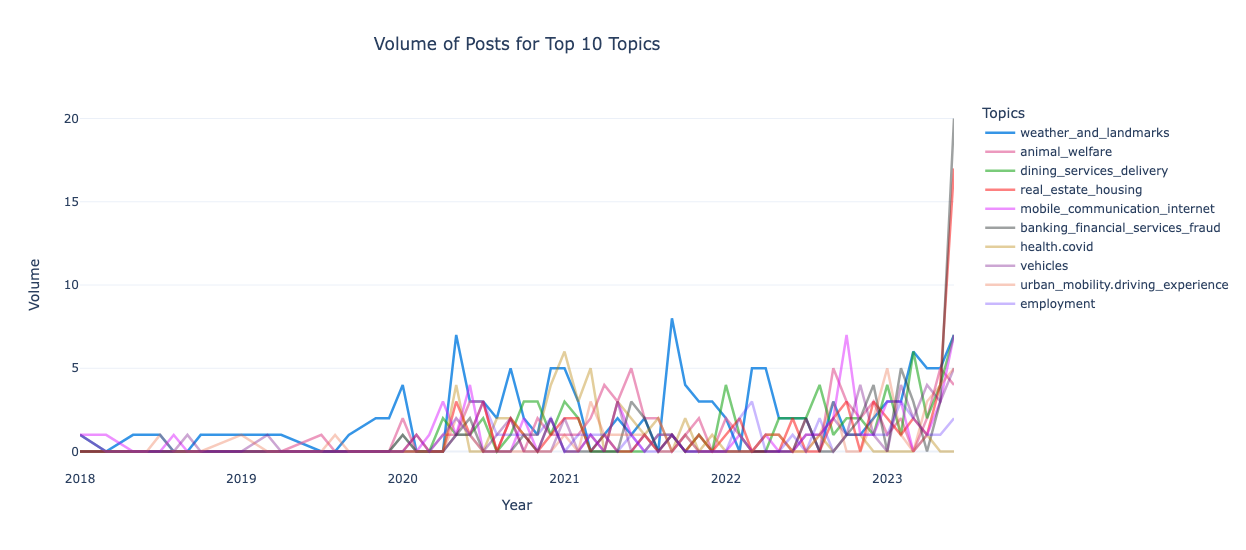

In [84]:
# Filter the data for the top 10 topics by volume
top_topics_data = df[df['human_labels'].isin(top_topics.index)]

# Group by month-year and topic to calculate the volume of posts for each topic
volume = top_topics_data.groupby(['month_year', 'human_labels']).size().unstack().fillna(0)

# Set alpha for each topic based on its volume
max_alpha = 1.0
min_alpha = 0.3
total_vol = volume.sum()
line_alpha = (total_vol/ total_vol.max() *(max_alpha - min_alpha)) + min_alpha

colors = px.colors.qualitative.Dark24

# Convert hex colors to RGB
rgb_colors = [mcolors.hex2color(color) for color in colors]

# Create the figure
fig = go.Figure()

#sort topics by volume
sorted_topics = total_vol.sort_values(ascending = False).index

# Plot line graphs with varying transparency based on volume
for idx, topic in enumerate(sorted_topics):
    r, g, b = rgb_colors[idx]
    rgba_color = f'rgba({int(r*255)},{int(g*255)},{int(b*255)},{line_alpha[topic]})'
    fig.add_trace(go.Scatter(x=volume.index.astype(str), 
                             y=volume[topic], 
                             mode='lines', 
                             name=topic, opacity = np.arange(0.6,1,.04)[::-1][idx],
                             line=dict(color=rgba_color, width=2.5)
                            ))

# Update the figure layout
fig.update_layout(
    title={"text": "Volume of Posts for Top 10 Topics", "x": 0.3},
    xaxis_title="Year",
    yaxis_title="Volume",
    legend=dict(title="Topics", x=1.03),
    xaxis_showgrid=False,
    xaxis=dict(zeroline=False),
    width=1200,
    height=550,
    autosize=False
)

# Display the figure
fig.show()

<span style="color: orange; font-family: Calibri Light;">
  <h4><b>ii. Top Engagements:</b></h4>
</span>
<span style = 'font-family: Calibri Light'>
    total number of posts for top 10 topics in the period</span>

In [47]:
#group by year and comments
top_comments = df.groupby('human_labels')['Total Comments'].sum().nlargest(10)

top_comments.sort_values()

human_labels
vehicles                                1075
mobile_communication_internet           1148
real_estate_housing                     1208
social_interactions                     1498
urban_mobility.driving_experience       1540
dining_experience.food                  1857
dining_services_delivery                2314
animal_welfare                          2508
entertainment_and_media_restrictions    2546
weather_and_landmarks                   4341
Name: Total Comments, dtype: int64

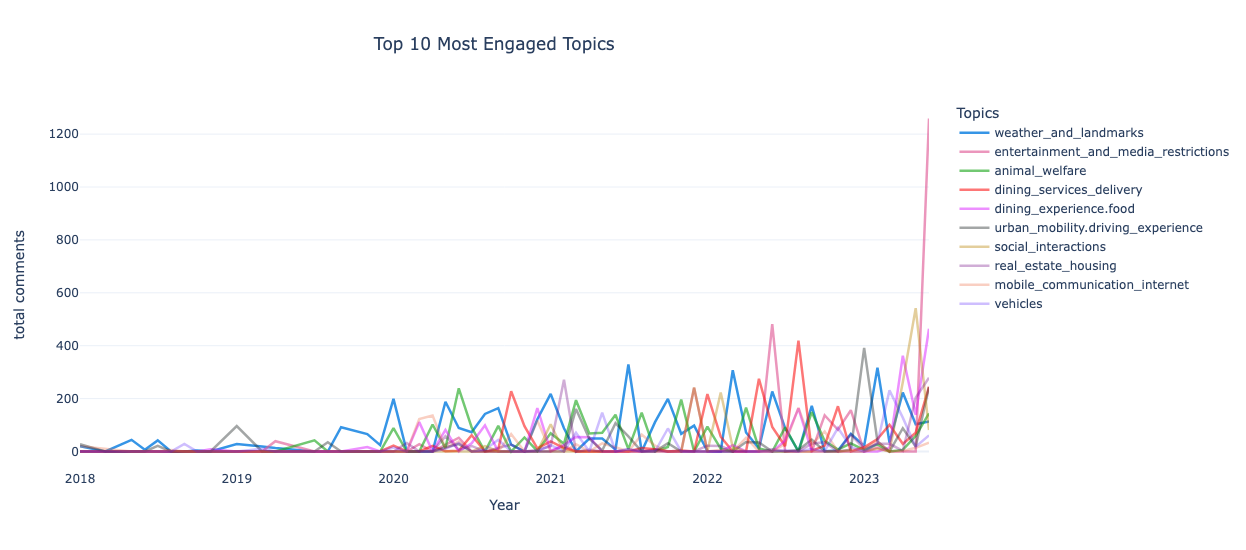

In [91]:
#data to plot
top_comments_data = df[df['human_labels'].isin(top_comments.index)]

comments = top_comments_data.groupby(['month_year','human_labels'])['Total Comments'].sum().unstack().fillna(0)


# Set alpha for each topic based on its volume
max_alpha = 1.0
min_alpha = 0.3
total_vol = comments.sum()
line_alpha = (total_vol/ total_vol.max() *(max_alpha - min_alpha)) + min_alpha

colors = px.colors.qualitative.Dark24

# Convert hex colors to RGB
rgb_colors = [mcolors.hex2color(color) for color in colors]

# Create the figure
fig = go.Figure()

#sort topics by volume
sorted_topics = total_vol.sort_values(ascending = False).index

# Plot line graphs with varying transparency based on volume
for idx, topic in enumerate(sorted_topics):
    r, g, b = rgb_colors[idx]
    rgba_color = f'rgba({int(r*255)},{int(g*255)},{int(b*255)},{line_alpha[topic]})'
    fig.add_trace(go.Scatter(x=comments.index.astype(str), 
                             y=comments[topic], 
                             mode='lines', 
                             name=topic, opacity = np.arange(0.6,1,.04)[::-1][idx],
                             line=dict(color=rgba_color, width=2.5)
                            ))

# Update the figure layout
fig.update_layout(
    title={"text": "Top 10 Most Engaged Topics", "x": 0.3},
    xaxis_title="Year",
    yaxis_title="total comments",
    legend=dict(title="Topics", x=1.03),
    xaxis_showgrid=False,
    xaxis=dict(
        zeroline=False),
    width=1200,
    height=550,
    autosize=False
)

# Display the figure
fig.show()

<span style="color: orange; font-family: Calibri Light;">
  <h4><b>iii. Topic Sentiments:</b></h4>
</span>
<span style = 'font-family: Calibri Light'>
    total number of posts for top 10 topics in the period</span>

In [49]:
#create general bins for upvotes - 'very positive', 'positive', 'neutral', 'negative', 'very negative'
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
upvote_data = top_comments_data.copy()
upvote_data['upvote_ratio_bin'] = pd.cut(upvote_data['upvote_ratio'], bins=bins, labels=labels, right=True)

upvote_data

,text_type,ID,date_created,long_text,topic,representation,human_labels,broad_categories,upvote_ratio,Score,Total Comments,year,month_year,upvote_ratio_bin
69,submission,7ntjdt,2018-01-03 13:12:09,Is your personal time better in winter than in...,1,"['expo', 'weather', 'summer', 'ac', 'burj khal...",weather_and_landmarks,environment,0.53,1,20,2018,2018-01,Neutral
72,submission,7q08qq,2018-01-13 02:22:20,Any of you got a call from your ISP warning yo...,19,"['etisalat', 'whatsapp', 'du', 'calls', 'data'...",mobile_communication_internet,environment,0.48,3,20,2018,2018-01,Neutral
74,submission,7tpcni,2018-01-29 07:03:09,Why are people indicating left when they’re go...,4,"['lane', 'limit', 'parking', 'traffic', 'faste...",urban_mobility.driving_experience,mobility,0.56,3,28,2018,2018-01,Neutral
80,submission,86rl9e,2018-03-24 11:22:35,I've been on the call with Etisalat support fo...,19,"['etisalat', 'whatsapp', 'du', 'calls', 'data'...",mobile_communication_internet,environment,0.50,0,9,2018,2018-03,Neutral
84,submission,8ges74,2018-05-02 08:39:42,To all those people who run out of metro What ...,1,"['expo', 'weather', 'summer', 'ac', 'burj khal...",weather_and_landmarks,environment,0.44,0,44,2018,2018-05,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,submission,13cpma4,2023-05-09 17:17:49,"UAE real estate agents and brokers, I need you...",12,"['real estate', 'properties', 'agents', 'villa...",real_estate_housing,living,0.50,0,16,2023,2023-05,Neutral
3643,submission,13p1nlq,2023-05-23 00:07:39,A Well Deserved Shout-out I posted in this sub...,3,"['tip', 'talabat', 'deliveroo', 'zomato', 'res...",dining_services_delivery,living,1.00,4,2,2023,2023-05,Very Positive
3644,submission,14d7052,2023-06-19 10:52:36,Furnished apartments… bedding/pots and pans Hi...,12,"['real estate', 'properties', 'agents', 'villa...",real_estate_housing,living,0.67,1,2,2023,2023-06,Positive
3685,submission,neivda,2021-05-17 19:13:39,where can i buy/adopt a cat that doesn’t cost ...,9,"['cats', 'pet', 'breed', 'rescue', 'adopt', 'b...",animal_welfare,living,0.44,0,22,2021,2021-05,Neutral


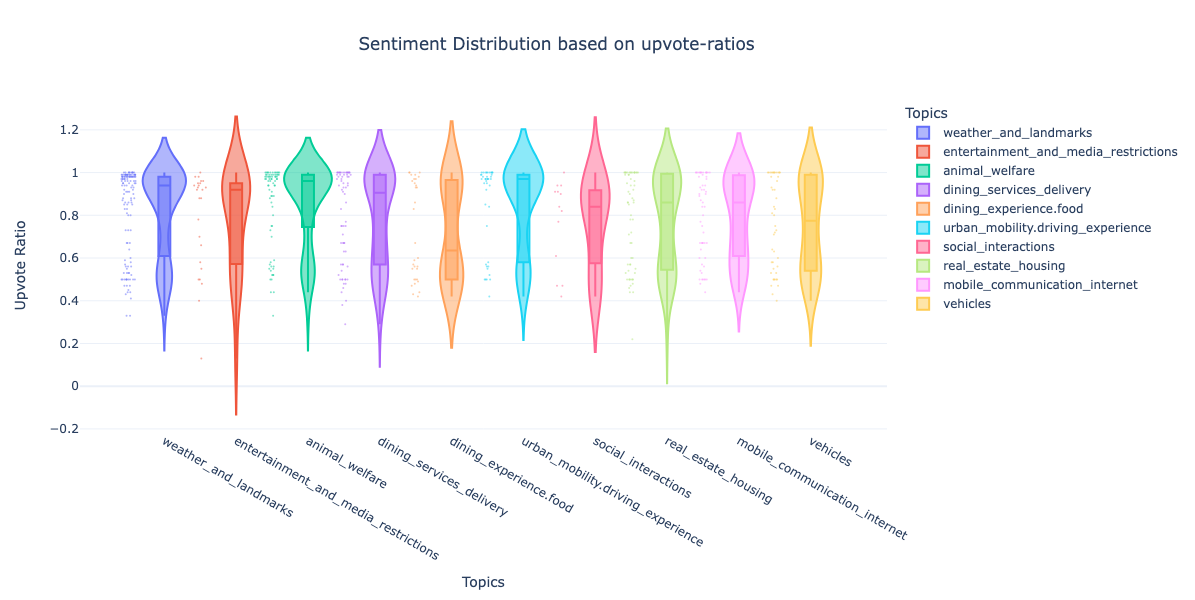

In [82]:
# Create a violin plot with Plotly
fig = px.violin(upvote_data, y="upvote_ratio", x="human_labels", color = "human_labels",
                box=True, points="all", title="Sentiment Distribution for Top 10 Topics",
                labels={"human_labels": "Topics", "upvote_ratio": "Upvote Ratio"}, height = 600,
                category_orders={"human_labels": top_comments.index.tolist()})

# Customize the appearance
fig.update_traces(marker=dict(size=2, opacity=0.5), selector=dict(type='violin'))
fig.update_layout(violingap=0.05, violingroupgap=0.3, 
                  violinmode="overlay", title={"text": "Sentiment Distribution based on upvote-ratios", "x": 0.3} )

# Show the plot
fig.show()

In [51]:
# Extract month from month_year for grouping
monthly_diversity = df.groupby(['year', 'month_year'])['human_labels'].nunique().reset_index()
monthly_diversity['month'] = monthly_diversity['month_year'].dt.month

# Pivot the monthly_diversity DataFrame to have years as columns and month as rows
pivot_diversity_month = monthly_diversity.pivot(index='month', columns='year', values='human_labels').fillna(0)

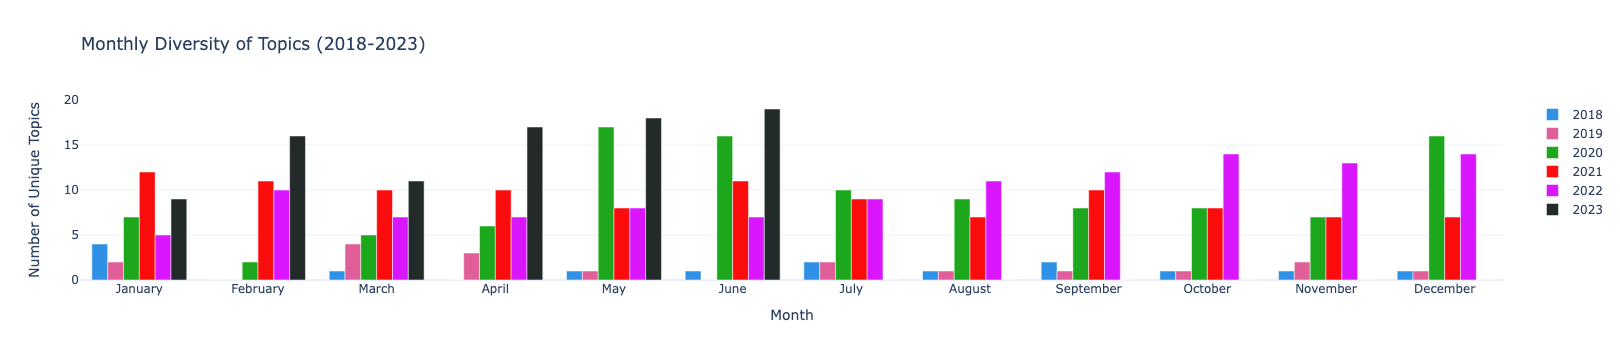

In [52]:
# Generate the grouped bar plot
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig = go.Figure()

for idx, year in enumerate(range(2018, 2024)):
    fig.add_trace(go.Bar(x=months, 
                         y=pivot_diversity_month[year], 
                         name=str(year), 
                         marker_color=colors[idx]))

# Update layout
fig.update_layout(
    title="Monthly Diversity of Topics (2018-2023)",
    xaxis_title="Month",
    yaxis_title="Number of Unique Topics",
    barmode='group'
)

fig.show()

<span style="color: orange; font-family: Calibri Light;">
  <h4><b>iv. Topic consistency:</b></h4>
</span>
<span style = 'font-family: Calibri Light'>
    topics discussed in every year for the period, and topics that were one off</span>

In [57]:
# Group by 'year' and aggregate the unique topics discussed in that year
topics_per_year = df.groupby('year')['topic'].unique()

# Identify the topics that appeared in all the specified years
common_topics = set(topics_per_year.iloc[0])
for topics in topics_per_year:
    common_topics = common_topics.intersection(set(topics))

common_topics


{1, 4, 7, 11}

In [62]:
#include topic labels
common_topic_labels = df[df['topic'].isin(common_topics)].groupby('topic').apply(lambda x: ", ".join(x['human_labels'].unique())).to_dict()

topic_and_labels = {}

for topic in common_topics:
    topic_and_labels[topic] = common_topic_labels[topic]

topic_and_labels

{1: 'weather_and_landmarks',
 11: 'vehicles',
 4: 'urban_mobility.driving_experience',
 7: 'dining_experience.food'}

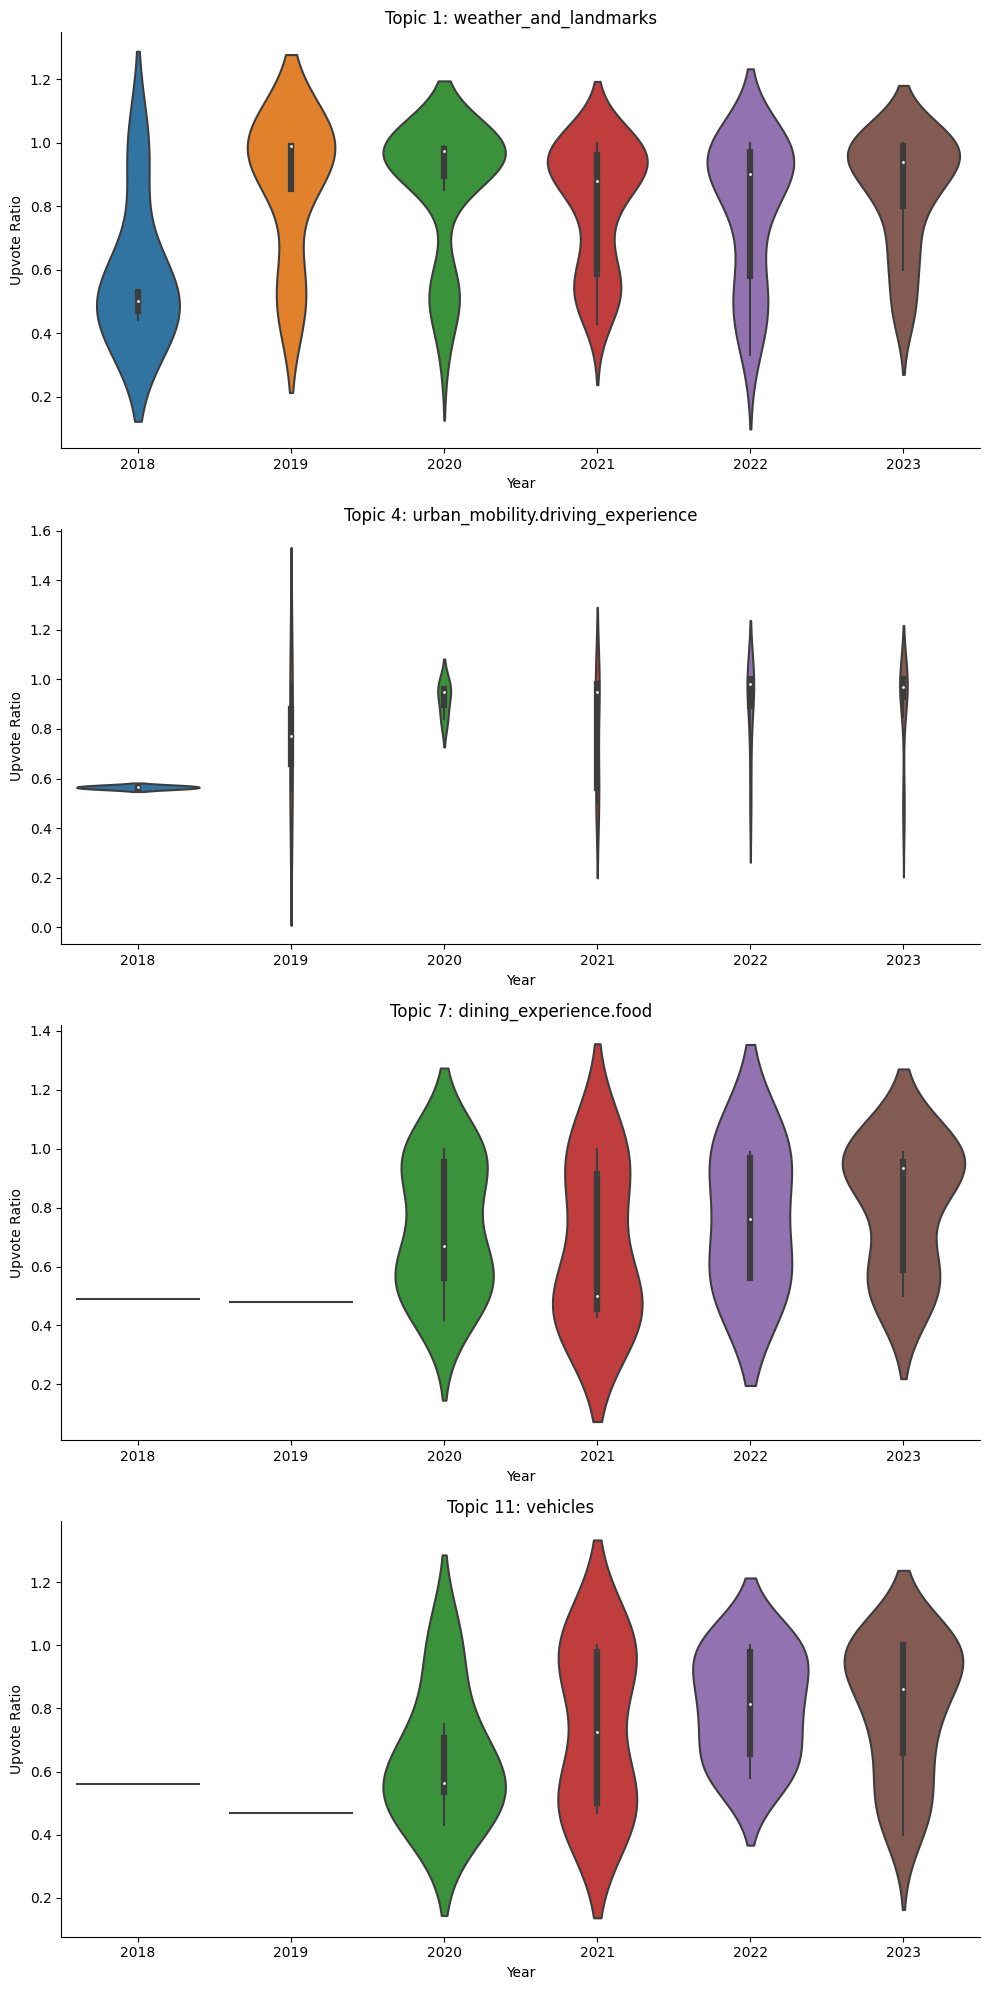

In [80]:
# Binning the upvote ratios
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

df.loc[:, 'upvote_ratio_bin'] = pd.cut(df['upvote_ratio'], bins=bins, labels=labels, right=True)

# Filtering for common topics
common_data = df[df['topic'].isin(common_topics)]
# Defining the topic_and_labels dictionary
topic_and_labels = common_topic_labels


# Setting up the figure and axes
fig, axs = plt.subplots(len(common_topics), 1, figsize=(10, 5 * len(common_topics)))

for ax, (topic, label) in zip(axs, topic_and_labels.items()):
    sns.violinplot(x='year', y='upvote_ratio', data=common_data[common_data['topic'] == topic], ax=ax)
    ax.set_title(f"Topic {topic}: {label}")
    ax.set_ylabel('Upvote Ratio')
    ax.set_xlabel('Year')
    sns.despine(ax=ax, right=True, top=True) 

plt.tight_layout()
plt.show()

In [68]:
# Identify the topics that appeared in only one year
unique_topics = {}

for year, topics in topics_per_year.items():
    for topic in topics:
        if topic in unique_topics:
            unique_topics[topic] += 1
        else:
            unique_topics[topic] = 1

rare_topics = [topic for topic, count in unique_topics.items() if count == 1]

#retrieve topic labels
rare_topic_labels = df[df['topic'].isin(rare_topics)].groupby('topic').apply(lambda x: ", ".join(x['human_labels'].unique())).to_dict()
rare_topics_and_labels = {}

for topic in rare_topics:
    rare_topics_and_labels[topic] = rare_topic_labels[topic]

rare_topics_and_labels

{32: 'child_behaviour_discipline',
 43: 'smoking_habits',
 44: 'communication_etiquette'}

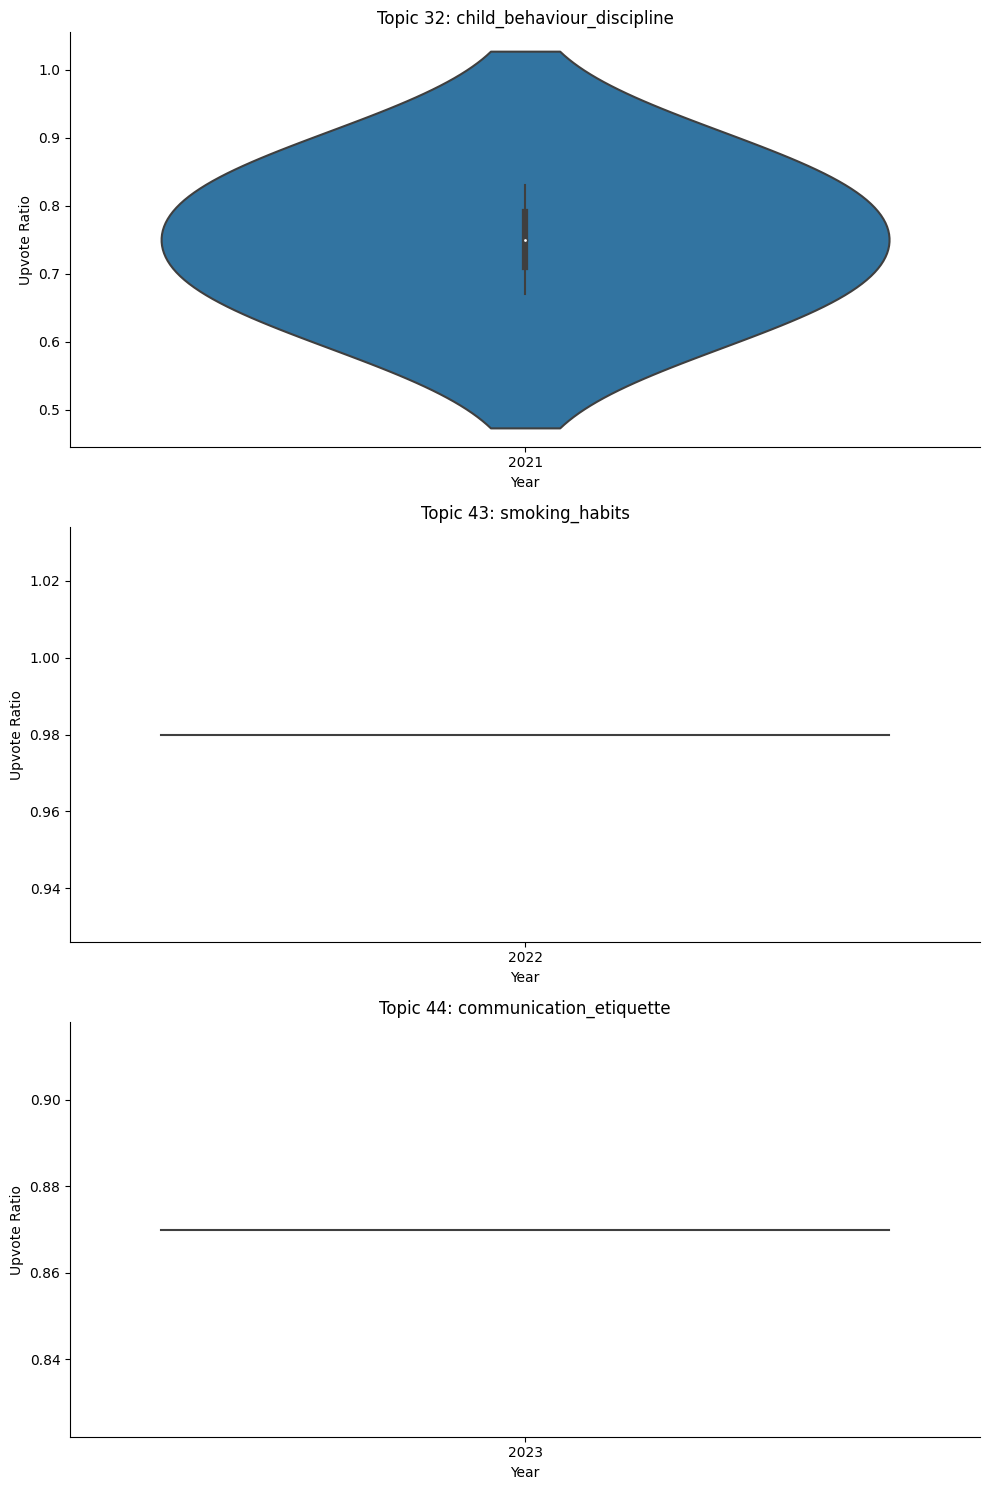

In [81]:
# Binning the upvote ratios
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

df.loc[:, 'upvote_ratio_bin'] = pd.cut(df['upvote_ratio'], bins=bins, labels=labels, right=True)

# Filtering for common topics
rare_data = df[df['topic'].isin(rare_topics)]
# Defining the topic_and_labels dictionary
topic_and_labels = rare_topic_labels


# Setting up the figure and axes
fig, axs = plt.subplots(len(rare_topics), 1, figsize=(10, 5 * len(rare_topics)))

for ax, (topic, label) in zip(axs, topic_and_labels.items()):
    sns.violinplot(x='year', y='upvote_ratio', data=rare_data[rare_data['topic'] == topic], ax=ax)
    ax.set_title(f"Topic {topic}: {label}")
    ax.set_ylabel('Upvote Ratio')
    ax.set_xlabel('Year')
    sns.despine(ax=ax, right=True, top=True) 

plt.tight_layout()
plt.show()